# 🎯 Advanced Sentiment Analysis Model Training
### Complete Guide with Multi-Dataset Fine-tuning and Sarcasm Detection
This comprehensive Jupyter notebook walks through building a robust sentiment analysis model using multiple datasets and state-of-the-art transformer architectures.

### 📑 Table of Contents
1. [Project Overview](#project-overview)
2. [Environment Setup](#environment-setup)
3. [Data Collection & Preparation](#data-collection--preparation)
4. [Model Architecture](#model-architecture)
5. [Training Process](#training-process)
6. [Evaluation & Visualization](#evaluation--visualization)
7. [Model Deployment](#model-deployment)
8. [Troubleshooting](#troubleshooting)

## 🎯 Project Overview
#### What We're Building
- Multi-dataset sentiment classifier combining Amazon reviews, IMDB movie reviews, and Stanford SST-2
- Sarcasm-aware model with custom sarcastic examples
- Production-ready classifier optimized for real-world deployment
- Cross-platform compatibility (Apple Silicon MPS, CUDA, CPU)
#### Key Features:
- ✅ Balanced dataset from multiple sources
- ✅ Advanced tokenization with proper padding/truncation
- ✅ Comprehensive evaluation with multiple metrics
- ✅ Visual analysis of dataset distribution and model performance
- ✅ Fallback model support for different hardware configurations

## 🛠️ Environment Setup


In [3]:
# Cell 1: Import Libraries and Setup
import os
import random
import warnings
warnings.filterwarnings('ignore')

# Data science & visualization
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# PyTorch and evaluation
import torch
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

# Hugging Face Transformers and datasets
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding
)
from datasets import load_dataset, Dataset
import logging

print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


## 🔧 Hardware Configuration

In [4]:
# Cell 2: Device Detection and Configuration
# Ensure proper memory management on Apple Silicon
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
os.environ["PYTORCH_MPS_HIGH_WATERMARK_RATIO"] = "0.0"

# Setup logger for detailed tracking
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Intelligent device detection
def detect_device():
    if torch.backends.mps.is_available():
        device = torch.device("mps")
        logger.info("🍎 Using Apple Silicon MPS acceleration")
        return device
    elif torch.cuda.is_available():
        device = torch.device("cuda")
        logger.info(f"🚀 Using CUDA GPU: {torch.cuda.get_device_name()}")
        return device
    else:
        device = torch.device("cpu")
        logger.info("💻 Using CPU (consider upgrading for faster training)")
        return device

torch_device = detect_device()
print(f"Selected device: {torch_device}")

# Check available memory
if torch_device.type == "cuda":
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
elif torch_device.type == "mps":
    print("MPS device detected - memory managed automatically")

2025-06-29 17:16:36,013 - INFO - 🍎 Using Apple Silicon MPS acceleration


Selected device: mps
MPS device detected - memory managed automatically


## 🎨 Visualization Setup

In [5]:
# Cell 3: Visualization Configuration
sns.set_style("whitegrid")
plt.rcParams.update({
    'figure.figsize': (12, 8),
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 11
})
# Color palette for consistent visualizations
colors = sns.color_palette("husl", 8)
print("🎨 Visualization setup complete!")

🎨 Visualization setup complete!


## 📊 Data Collection & Preparation
### 🏷️ Label Mapping and Custom Examples

In [6]:
# Cell 4: Define Labels and Custom Sarcasm Examples
# Binary classification: Like (1) vs Dislike (0)
LABEL_MAP = {"Dislike": 0, "Like": 1}

# Custom sarcasm examples to improve model's understanding of irony
custom_sarcasm_examples = [
    # Sarcastic negative examples
    ("Oh great, another amazing product!", "Dislike"),
    ("Perfect, just what I didn't need", "Dislike"),
    ("Fantastic service, if you enjoy waiting 3 hours", "Dislike"),
    ("What a brilliant idea - not!", "Dislike"),
    ("I'm thrilled it arrived broken", "Dislike"),
    ("Wonderful customer service, they hung up on me", "Dislike"),
    ("Amazing quality, it broke immediately", "Dislike"),
    ("Love how it doesn't work at all", "Dislike"),
    ("Great design, really user-friendly", "Dislike"),
    ("So helpful, they ignored all my questions", "Dislike"),
    
    # Genuine positive examples
    ("I absolutely love this product", "Like"),
    ("Excellent quality and fast shipping", "Like"),
    ("Highly recommend to everyone", "Like"),
    ("Outstanding customer service", "Like"),
    ("Perfect for my needs", "Like"),
    ("Great value for money", "Like"),
    ("Works exactly as described", "Like"),
    ("Very satisfied with purchase", "Like"),
    ("Top quality materials", "Like"),
    ("Exceeded my expectations", "Like"),
    
    # Clear negative examples
    ("Terrible product, complete waste of money", "Dislike"),
    ("Worst purchase I've ever made", "Dislike"),
    ("Broke after one day", "Dislike"),
    ("Would not recommend to anyone", "Dislike"),
    ("Poor quality and overpriced", "Dislike"),
    ("Completely useless", "Dislike"),
    ("Customer service was horrible", "Dislike"),
    ("Doesn't work as advertised", "Dislike"),
    ("Cheaply made and overpriced", "Dislike"),
    ("Save your money, buy something else", "Dislike")
]

print(f"📝 Created {len(custom_sarcasm_examples)} custom training examples")
print(f"🏷️ Label mapping: {LABEL_MAP}")

📝 Created 30 custom training examples
🏷️ Label mapping: {'Dislike': 0, 'Like': 1}


## 🔤 Tokenization Function

In [8]:
# Cell 5: Advanced Tokenization Function
def tokenize_function(examples, tokenizer, max_length=128):
    """
    Advanced tokenization with text cleaning and proper formatting
    
    Args:
        examples: Batch of text examples
        tokenizer: HuggingFace tokenizer
        max_length: Maximum sequence length
    
    Returns:
        Dictionary with tokenized inputs and labels
    """
    # Clean text: remove extra whitespace and normalize
    cleaned_texts = []
    for text in examples['text']:
        # Remove extra whitespace and normalize
        cleaned = ' '.join(str(text).split())
        cleaned_texts.append(cleaned)
    
    # Tokenize with proper padding and truncation
    encoded = tokenizer(
        cleaned_texts,
        truncation=True,
        padding=False,  # We'll pad dynamically during training
        max_length=max_length,
        return_tensors=None
    )
    
    # Convert string labels to integers
    encoded['labels'] = [LABEL_MAP[label] for label in examples['label']]
    
    return encoded

print("🔤 Tokenization function defined successfully!")

🔤 Tokenization function defined successfully!


## 📈 Evaluation Metrics

In [7]:
# Cell 6: Comprehensive Evaluation Metrics
def compute_metrics(eval_pred):
    """
    Compute comprehensive evaluation metrics
    
    Args:
        eval_pred: Tuple of (predictions, labels)
    
    Returns:
        Dictionary of evaluation metrics
    """
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    
    # Calculate multiple metrics for comprehensive evaluation
    metrics = {
        "accuracy": accuracy_score(labels, predictions),
        "f1_weighted": f1_score(labels, predictions, average='weighted'),
        "f1_macro": f1_score(labels, predictions, average='macro'),
        "f1_micro": f1_score(labels, predictions, average='micro')
    }
    
    # Add per-class F1 scores
    f1_per_class = f1_score(labels, predictions, average=None)
    metrics["f1_dislike"] = f1_per_class[0]
    metrics["f1_like"] = f1_per_class[1]
    
    return metrics

print("📊 Evaluation metrics function ready!")

📊 Evaluation metrics function ready!


## 🗂️ Dataset Creation and Analysis {#data}
### 📦 Multi-Source Dataset Builder

In [9]:
# Cell 7: Advanced Dataset Creation
def create_diverse_dataset(max_per_source=2000, show_progress=True):
    """
    Create a balanced, diverse dataset from multiple sources
    
    Args:
        max_per_source: Maximum samples per source
        show_progress: Whether to show loading progress
    
    Returns:
        List of dataset records
    """
    logger.info("📦 Starting dataset creation...")
    dataset_list = []
    
    def create_records(data, label, source_name):
        """Helper function to create standardized records"""
        return [{"text": str(item), "label": label, "source": source_name} for item in data]
    
    # 1. Amazon Product Reviews
    if show_progress:
        print("🛒 Loading Amazon reviews...")
    try:
        amazon_data = load_dataset("amazon_polarity", split="train")
        print(f"   ✅ Loaded {len(amazon_data)} Amazon reviews")
        
        # Extract positive and negative reviews
        positive_amazon = [item["content"] for item in amazon_data if item["label"] == 1][:max_per_source]
        negative_amazon = [item["content"] for item in amazon_data if item["label"] == 0][:max_per_source]
        
        dataset_list.extend(create_records(positive_amazon, "Like", "amazon"))
        dataset_list.extend(create_records(negative_amazon, "Dislike", "amazon"))
        
    except Exception as e:
        logger.error(f"Failed to load Amazon dataset: {e}")
    
    # 2. IMDB Movie Reviews
    if show_progress:
        print("🎬 Loading IMDB movie reviews...")
    try:
        imdb_data = load_dataset("imdb", split="train")
        print(f"   ✅ Loaded {len(imdb_data)} IMDB reviews")
        
        # Truncate long reviews and extract samples
        positive_imdb = [item["text"][:500] for item in imdb_data if item["label"] == 1][:max_per_source]
        negative_imdb = [item["text"][:500] for item in imdb_data if item["label"] == 0][:max_per_source]
        
        dataset_list.extend(create_records(positive_imdb, "Like", "imdb"))
        dataset_list.extend(create_records(negative_imdb, "Dislike", "imdb"))
        
    except Exception as e:
        logger.error(f"Failed to load IMDB dataset: {e}")
    
    # 3. Stanford SST-2 Dataset
    if show_progress:
        print("🏫 Loading Stanford SST-2 dataset...")
    try:
        sst_data = load_dataset("sst2", split="train")
        print(f"   ✅ Loaded {len(sst_data)} SST-2 sentences")
        
        # Convert SST-2 format to our format
        sst_samples = sst_data.select(range(min(max_per_source * 2, len(sst_data))))
        for item in sst_samples:
            label = "Like" if item["label"] == 1 else "Dislike"
            dataset_list.append({"text": item["sentence"], "label": label, "source": "sst2"})
            
    except Exception as e:
        logger.error(f"Failed to load SST-2 dataset: {e}")
    
    # 4. Add Custom Sarcasm Examples
    if show_progress:
        print("🎭 Adding custom sarcasm examples...")
    dataset_list.extend([
        {"text": text, "label": label, "source": "custom_sarcasm"} 
        for text, label in custom_sarcasm_examples
    ])
    
    print(f"📊 Total raw samples collected: {len(dataset_list)}")
    return dataset_list

# Create the dataset
raw_dataset = create_diverse_dataset(max_per_source=1500)

2025-06-29 17:21:58,955 - INFO - 📦 Starting dataset creation...


🛒 Loading Amazon reviews...
   ✅ Loaded 3600000 Amazon reviews
🎬 Loading IMDB movie reviews...
   ✅ Loaded 25000 IMDB reviews
🏫 Loading Stanford SST-2 dataset...
   ✅ Loaded 67349 SST-2 sentences
🎭 Adding custom sarcasm examples...
📊 Total raw samples collected: 9030


## 📊 Dataset Balancing and Analysis

📈 Original Dataset Statistics:
Total samples: 9030

Label distribution:
label
Like       4648
Dislike    4382
Name: count, dtype: int64

Source distribution:
source
amazon            3000
imdb              3000
sst2              3000
custom_sarcasm      30
Name: count, dtype: int64

⚖️ Balancing to 4382 samples per label...
✅ Final balanced dataset: 8764 samples


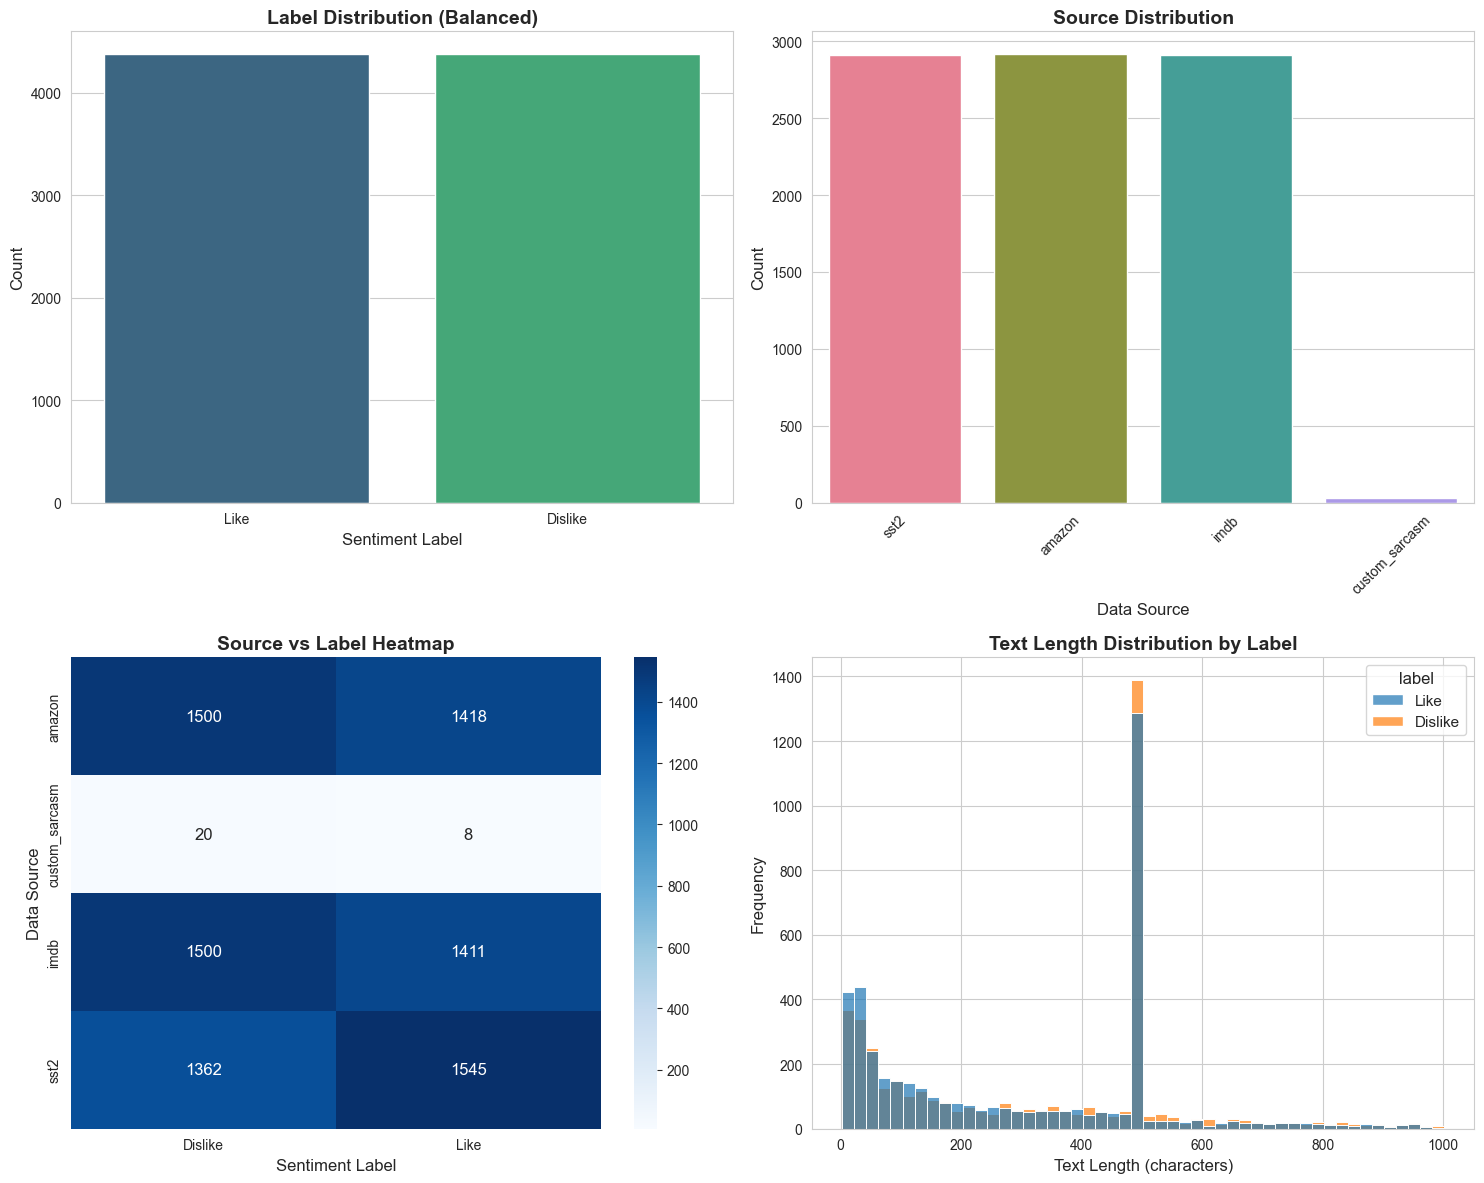


📝 Sample texts from each source:

SST2:
  [Dislike] patchy combination of soap opera , low-tech magic realism and , at times , ploddingly sociological c...
  [Like] like brosnan 's performance ...

AMAZON:
  [Like] So far the tablet has been really fun along with helpfull. I origanly got it so that my wife could a...
  [Dislike] Let me give you some advice that will keep you from pulling your hair straight out of your scalp... ...

IMDB:
  [Dislike] I almost called HBO and demanded my money back for the month just because they've been airing this m...
  [Dislike] I'm sorry, I had high hopes for this movie. Unfortunately, it was too long, too thin and too weak to...

CUSTOM_SARCASM:
  [Like] Top quality materials...
  [Like] Outstanding customer service...


In [10]:
# Cell 8: Dataset Balancing and Visualization
def balance_and_analyze_dataset(raw_data):
    """
    Balance dataset and create comprehensive visualizations
    
    Args:
        raw_data: List of raw dataset records
    
    Returns:
        Balanced dataset as list of records
    """
    # Convert to DataFrame for easier manipulation
    df = pd.DataFrame(raw_data)
    
    print("📈 Original Dataset Statistics:")
    print(f"Total samples: {len(df)}")
    print("\nLabel distribution:")
    print(df['label'].value_counts())
    print("\nSource distribution:")
    print(df['source'].value_counts())
    
    # Balance the dataset
    min_label_count = df['label'].value_counts().min()
    print(f"\n⚖️ Balancing to {min_label_count} samples per label...")
    
    balanced_df = pd.concat([
        df[df['label'] == 'Like'].sample(n=min_label_count, random_state=42),
        df[df['label'] == 'Dislike'].sample(n=min_label_count, random_state=42)
    ])
    
    # Shuffle the dataset
    balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)
    
    print(f"✅ Final balanced dataset: {len(balanced_df)} samples")
    
    # Create comprehensive visualizations
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Label distribution
    sns.countplot(data=balanced_df, x='label', ax=axes[0,0], palette='viridis')
    axes[0,0].set_title('Label Distribution (Balanced)', fontsize=14, fontweight='bold')
    axes[0,0].set_xlabel('Sentiment Label')
    axes[0,0].set_ylabel('Count')
    
    # 2. Source distribution
    sns.countplot(data=balanced_df, x='source', ax=axes[0,1], palette='husl')
    axes[0,1].set_title('Source Distribution', fontsize=14, fontweight='bold')
    axes[0,1].set_xlabel('Data Source')
    axes[0,1].set_ylabel('Count')
    axes[0,1].tick_params(axis='x', rotation=45)
    
    # 3. Source vs Label heatmap
    cross_tab = pd.crosstab(balanced_df['source'], balanced_df['label'])
    sns.heatmap(cross_tab, annot=True, fmt='d', cmap='Blues', ax=axes[1,0])
    axes[1,0].set_title('Source vs Label Heatmap', fontsize=14, fontweight='bold')
    axes[1,0].set_xlabel('Sentiment Label')
    axes[1,0].set_ylabel('Data Source')
    
    # 4. Text length distribution
    balanced_df['text_length'] = balanced_df['text'].str.len()
    sns.histplot(data=balanced_df, x='text_length', hue='label', bins=50, ax=axes[1,1], alpha=0.7)
    axes[1,1].set_title('Text Length Distribution by Label', fontsize=14, fontweight='bold')
    axes[1,1].set_xlabel('Text Length (characters)')
    axes[1,1].set_ylabel('Frequency')
    
    plt.tight_layout()
    plt.savefig('dataset_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print some sample texts
    print("\n📝 Sample texts from each source:")
    for source in balanced_df['source'].unique():
        print(f"\n{source.upper()}:")
        sample = balanced_df[balanced_df['source'] == source].sample(2)
        for idx, row in sample.iterrows():
            print(f"  [{row['label']}] {row['text'][:100]}...")
    
    return balanced_df.to_dict('records')

# Balance and analyze the dataset
balanced_dataset = balance_and_analyze_dataset(raw_dataset)

## 🤖 Model Architecture and Training 
### 🏗️ Model Training Function

In [ ]:
# Cell 9: Advanced Model Training Pipeline
import transformers

def train_sentiment_model(
    model_name="distilbert-base-uncased",
    dataset_records=None,
    max_length=128,
    batch_size=16,
    learning_rate=2e-5,
    num_epochs=3,
    eval_steps=500
):
    """
    Complete model training pipeline with advanced configuration
    
    Args:
        model_name: HuggingFace model identifier
        dataset_records: List of dataset records
        max_length: Maximum sequence length
        batch_size: Training batch size
        learning_rate: Learning rate for training
        num_epochs: Number of training epochs
        eval_steps: Steps between evaluations
    
    Returns:
        Tuple of (trained_model, tokenizer, trainer)
    """
    
    logger.info(f"🚀 Starting training with {model_name}")
    
    # 1. Load tokenizer and model
    print("🔤 Loading tokenizer...")
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    
    # Add padding token if not present
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
    
    print("🤖 Loading model...")
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=2,
        id2label={0: "Dislike", 1: "Like"},
        label2id={"Dislike": 0, "Like": 1},
        ignore_mismatched_sizes=True
    )
    
    # Move model to device
    model = model.to(torch_device)
    print(f"✅ Model loaded on {torch_device}")
    
    # 2. Prepare datasets
    print("📊 Preparing datasets...")
    dataset = Dataset.from_list(dataset_records)
    
    # Tokenize the dataset
    tokenized_dataset = dataset.map(
        lambda x: tokenize_function(x, tokenizer, max_length),
        batched=True,
        remove_columns=["text", "label", "source"]
    )
    
    # Split dataset: 70% train, 15% validation, 15% test
    train_test_split = tokenized_dataset.train_test_split(test_size=0.3, seed=42)
    val_test_split = train_test_split["test"].train_test_split(test_size=0.5, seed=42)
    
    train_dataset = train_test_split["train"]
    val_dataset = val_test_split["train"]
    test_dataset = val_test_split["test"]
    
    print(f"📈 Dataset splits:")
    print(f"  Training: {len(train_dataset)} samples")
    print(f"  Validation: {len(val_dataset)} samples")
    print(f"  Test: {len(test_dataset)} samples")
    
    # 3. Configure training arguments
    output_dir = f"./results_{model_name.replace('/', '_')}"
    
    training_args = TrainingArguments(
        output_dir="./results",
        do_eval=True,
        eval_strategy="steps",
        eval_steps=200,
        save_strategy="steps",
        save_steps=200,
        learning_rate=2e-5,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        num_train_epochs=2,
        weight_decay=0.01,
        logging_dir="./logs",
        logging_steps=50,
        load_best_model_at_end=True,
        metric_for_best_model="f1_weighted",
        greater_is_better=True,
        save_total_limit=2,
        fp16=torch_device.type == "cuda",
        bf16=False
    )
    
    # 4. Initialize trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
        data_collator=DataCollatorWithPadding(tokenizer=tokenizer)
    )
    
    # 5. Train the model
    print("🏋️ Starting training...")
    training_result = trainer.train()
    
    print("✅ Training completed!")
    print(f"Training time: {training_result.metrics['train_runtime']:.2f} seconds")
    print(f"Training samples/second: {training_result.metrics['train_samples_per_second']:.2f}")
    
    return model, tokenizer, trainer, test_dataset

# Start training
model, tokenizer, trainer, test_dataset = train_sentiment_model(
    model_name="distilbert-base-uncased",
    dataset_records=balanced_dataset,
    max_length=128,
    batch_size=8,  # Adjust based on your hardware
    learning_rate=2e-5,
    num_epochs=3,
    eval_steps=300
)

## 📊 Model Evaluation and Visualization 
### 🎯 Comprehensive Model Evaluation

In [ ]:
# Cell 10: Detailed Model Evaluation
def evaluate_model_comprehensively(trainer, test_dataset, tokenizer):
    """
    Perform comprehensive model evaluation with visualizations
    
    Args:
        trainer: Trained HuggingFace trainer
        test_dataset: Test dataset
        tokenizer: Model tokenizer
    
    Returns:
        Dictionary of evaluation results
    """
    
    print("📊 Performing comprehensive evaluation...")
    
    # 1. Get predictions on test set
    predictions = trainer.predict(test_dataset)
    y_true = predictions.label_ids
    y_pred = np.argmax(predictions.predictions, axis=-1)
    y_probs = torch.softmax(torch.tensor(predictions.predictions), dim=-1)
    
    # 2. Calculate metrics
    results = {
        'accuracy': accuracy_score(y_true, y_pred),
        'f1_weighted': f1_score(y_true, y_pred, average='weighted'),
        'f1_macro': f1_score(y_true, y_pred, average='macro'),
        'f1_micro': f1_score(y_true, y_pred, average='micro')
    }
    
    # 3. Print detailed classification report
    print("\n📝 Detailed Classification Report:")
    print("=" * 50)
    report = classification_report(
        y_true, y_pred, 
        target_names=["Dislike", "Like"],
        digits=4
    )
    print(report)
    
    # 4. Create visualizations
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(
        cm, annot=True, fmt='d', cmap='Blues',
        xticklabels=["Dislike", "Like"],
        yticklabels=["Dislike", "Like"],
        ax=axes[0,0]
    )
    axes[0,0].set_title('Confusion Matrix', fontsize=14, fontweight='bold')
    axes[0,0].set_xlabel('Predicted Label')
    axes[0,0].set_ylabel('True Label')
    
    # Prediction Confidence Distribution
    confidence_scores = np.max(y_probs.numpy(), axis=1)
    correct_predictions = (y_true == y_pred)
    
    axes[0,1].hist(confidence_scores[correct_predictions], alpha=0.7, label='Correct', bins=20, color='green')
    axes[0,1].hist(confidence_scores[~correct_predictions], alpha=0.7, label='Incorrect', bins=20, color='red')
    axes[0,1].set_title('Prediction Confidence Distribution', fontsize=14, fontweight='bold')
    axes[0,1].set_xlabel('Confidence Score')
    axes[0,1].set_ylabel('Frequency')
    axes[0,1].legend()
    
    # Per-class Performance
    f1_scores = f1_score(y_true, y_pred, average=None)
    class_names = ['Dislike', 'Like']
    bars = axes[1,0].bar(class_names, f1_scores, color=['red', 'green'], alpha=0.7)
    axes[1,0].set_title('F1-Score by Class', fontsize=14, fontweight='bold')
    axes[1,0].set_ylabel('F1-Score')
    axes[1,0].set_ylim(0, 1)
    
    # Add value labels on bars
    for bar, score in zip(bars, f1_scores):
        height = bar.get_height()
        axes[1,0].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                      f'{score:.3f}', ha='center', va='bottom')
    
    # Training History (if available)
    try:
        log_history = trainer.state.log_history
        train_loss = [log['train_loss'] for log in log_history if 'train_loss' in log]
        eval_loss = [log['eval_loss'] for log in log_history if 'eval_loss' in log]
        
        steps_train = range(len(train_loss))
        steps_eval = [i * (len(train_loss) // len(eval_loss)) for i in range(len(eval_loss))]
        
        axes[1,1].plot(steps_train, train_loss, label='Training Loss', color='blue')
        axes[1,1].plot(steps_eval, eval_loss, label='Validation Loss', color='orange')
        axes[1,1].set_title('Training History', fontsize=14, fontweight='bold')
        axes[1,1].set_xlabel('Training Steps')
        axes[1,1].set_ylabel('Loss')
        axes[1,1].legend()
        
    except Exception as e:
        axes[1,1].text(0.5, 0.5, 'Training history\nnot available', 
                      ha='center', va='center', transform=axes[1,1].transAxes)
        axes[1,1].set_title('Training History', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('model_evaluation.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 5. Show some prediction examples
    print("\n🔍 Sample Predictions:")
    print("=" * 50)
    
    # Convert test dataset back to text for display
    sample_indices = np.random.choice(len(test_dataset), 5, replace=False)
    
    for idx in sample_indices:
        # Get the tokenized input
        input_ids = test_dataset[idx]['input_ids']
        true_label = test_dataset[idx]['labels']
        
        # Decode back to text
        text = tokenizer.decode(input_ids, skip_special_tokens=True)
        
        # Get prediction
        pred_label = y_pred[idx]
        confidence = confidence_scores[idx]
        
        # Format output
        true_sentiment = "Like" if true_label == 1 else "Dislike"
        pred_sentiment = "Like" if pred_label == 1 else "Dislike"
        status = "✅" if true_label == pred_label else "❌"
        
        print(f"{status} Text: {text[:100]}...")
        print(f"   True: {true_sentiment} | Predicted: {pred_sentiment} | Confidence: {confidence:.3f}")
        print()
    
    return results

# Evaluate the model
evaluation_results = evaluate_model_comprehensively(trainer, test_dataset, tokenizer)